<a href="https://colab.research.google.com/github/kaushalkahapola/hand-gesture-recognition/blob/main/hand_gesture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Get the dataset from Kaggle

## About Dataset

### Context

Hand gesture recognition database is presented, composed by a set of near infrared images acquired by the Leap Motion sensor.

### Content

The database is composed by 10 different hand-gestures (showed above) that were performed by 10 different subjects (5 men and 5 women).

The database is structured in different folders as:

* /00 (subject with identifier 00)

    * /01_palm (images for palm gesture of subject 00 )

    * /01_palm/frame_197957_r.png,…,frame_198136_l.png, … (images that corresponds to different samples obtained for the palm gesture performed by the subject with identifier 00)

    * /02_l (images for l gesture of subject 00 )
    /10_down

* /01

* /02

* /09 (last subject with identifier 09)

Every root folder (00, 01,…) contains the infrared images of one subject. The folder name is the identifier of each different subject.

https://www.kaggle.com/datasets/gti-upm/leapgestrecog/data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
data_path = '/content/drive/MyDrive/hand_gesture_data'
os.makedirs(data_path, exist_ok=True)

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                                  title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
berkayalan/paris-2024-olympics-medals                                Paris 2024 Olympics Medals                           1KB  2024-08-14 11:02:45           4630         85  1.0              
abdullahashfaqvirk/student-mental-health-survey                      Student Mental Health Survey                         2KB  2024-08-23 15:38:57           2078         36  0.88235295       
haseebindata/student-performance-predictions                         Student Performance Predictions                      9KB  2024-08-17 06:57:57           4836        103  0.9411765        
willianoliveiragibin/olympics-2024      

In [ ]:
!kaggle datasets download -d gti-upm/leapgestrecog -p /content/drive/MyDrive/hand_gesture_data

Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0
100% 2.13G/2.13G [00:26<00:00, 106MB/s] 
100% 2.13G/2.13G [00:26<00:00, 85.5MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/hand_gesture_data/leapgestrecog.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/hand_gesture_data')


In [ ]:
# import os

# for root, dirs, files in os.walk('/content/drive/MyDrive/hand_gesture_data/leapgestrecog'):
#     print(root, dirs, files)


# 2. Preparing the data

In [ ]:
def get_image_paths_and_labels(base_dir):
    image_paths = []
    labels = []

    # Loop through each subject's folder
    for subject in os.listdir(base_dir):
        subject_path = os.path.join(base_dir, subject)

        # Loop through each gesture folder
        for gesture in os.listdir(subject_path):
            gesture_path = os.path.join(subject_path, gesture)

            # Loop through each image file
            for img_file in os.listdir(gesture_path):
                image_paths.append(os.path.join(gesture_path, img_file))
                labels.append(gesture)  # Assuming gesture folder names are the labels

    return image_paths, labels

In [ ]:
import os

data_dir = '/content/drive/MyDrive/hand_gesture_data/leapGestRecog'
image_paths, labels = get_image_paths_and_labels(data_dir)

In [ ]:
print("Number of images:", len(image_paths))
print("Number of labels:", len(labels))

Number of images: 20000
Number of labels: 20000


In [ ]:
for i in range(5):  # Display the first 5 samples
    print(f"Image Path: {image_paths[i]}")
    print(f"Label: {labels[i]}")
    print("---")


Image Path: /content/drive/MyDrive/hand_gesture_data/leapGestRecog/00/01_palm/frame_00_01_0001.png
Label: 01_palm
---
Image Path: /content/drive/MyDrive/hand_gesture_data/leapGestRecog/00/01_palm/frame_00_01_0002.png
Label: 01_palm
---
Image Path: /content/drive/MyDrive/hand_gesture_data/leapGestRecog/00/01_palm/frame_00_01_0003.png
Label: 01_palm
---
Image Path: /content/drive/MyDrive/hand_gesture_data/leapGestRecog/00/01_palm/frame_00_01_0004.png
Label: 01_palm
---
Image Path: /content/drive/MyDrive/hand_gesture_data/leapGestRecog/00/01_palm/frame_00_01_0005.png
Label: 01_palm
---


In [ ]:
import os

for path in image_paths[:5]:  # Check the first 5 paths
    if not os.path.isfile(path):
        print(f"File not found: {path}")


In [ ]:
unique_labels = set(labels)
print("Unique Labels:", unique_labels)


Unique Labels: {'01_palm', '02_l', '03_fist', '04_fist_moved', '09_c', '08_palm_moved', '10_down', '06_index', '05_thumb', '07_ok'}


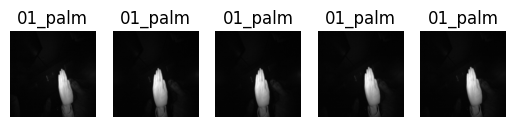

In [ ]:
import matplotlib.pyplot as plt
import cv2

def show_images(image_paths, labels, num_images=5):
    for i in range(num_images):
        img = cv2.imread(image_paths[i], cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224, 224))  # Resize to the size expected by the model
        plt.subplot(1, num_images, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

show_images(image_paths, labels)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation for training data
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define data generator without augmentation for validation data
val_datagen = ImageDataGenerator()


In [ ]:
import numpy as np
y_labels = np.array(labels)
y_labels

array(['01_palm', '01_palm', '01_palm', ..., '10_down', '10_down',
       '10_down'], dtype='<U13')

In [ ]:
unique_classes = np.unique(y_labels)
unique_classes

array(['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb',
       '06_index', '07_ok', '08_palm_moved', '09_c', '10_down'],
      dtype='<U13')

In [ ]:
boolean_y = [label == unique_classes for label in y_labels]
boolean_y[:2]

[array([ True, False, False, False, False, False, False, False, False,
        False]),
 array([ True, False, False, False, False, False, False, False, False,
        False])]

In [ ]:
X = np.array(image_paths)
y = np.array(boolean_y)

# Set number of images to use for experimenting
NUM_IMAGES = 1000

# split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [ ]:
X_train[:1], y_train[:1]

(array(['/content/drive/MyDrive/hand_gesture_data/leapGestRecog/00/01_palm/frame_00_01_0030.png'],
       dtype='<U92'),
 array([[ True, False, False, False, False, False, False, False, False,
         False]]))

In [ ]:
import tensorflow as tf

In [ ]:
# Image Size define
IMG_SIZE = 224

def process_image(path,img_size=IMG_SIZE):
  """
  Takes an image file path and turns into a tensor
  """

  #read in an image file
  image = tf.io.read_file(path)

  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=1)

  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=(img_size,img_size))

  return image

In [ ]:
def get_image_label(image_path, label):
  """
  Takes an image file path name and the assosciated label,
  processes the image and reutrns a typle of (image, label).
  """
  return process_image(image_path), label

In [ ]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the iamge path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [ ]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [ ]:
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 10), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 10), dtype=tf.bool, name=None)))

# 3. Traning Our Model with a subset of our data

In [ ]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 1] # batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_classes)

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [ ]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE):

  # Define your model
  model = Sequential([
      Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
      MaxPooling2D((2, 2)),
      Flatten(),
      Dense(128, activation='relu'),
      Dense(units=output_shape, activation='softmax')  # Number of classes
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build()

  return model

In [ ]:
model = create_model()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 394272)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      50,466,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,468,554 (192.52 MB)

 Trainable params: 50,468,554 (192.52 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

In [ ]:
NUM_EPOCHS = 100

# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()


  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[early_stopping])
  # Return the fitted model
  return model

In [ ]:
# Fit the model to the data
model = train_model()

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 388s 15s/step - accuracy: 0.4985 - loss: 4.4088 - val_accuracy: 0.9900 - val_loss: 0.0460
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 60s 175ms/step - accuracy: 0.9861 - loss: 0.0530 - val_accuracy: 1.0000 - val_loss: 0.0112
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 1.0000 - loss: 0.0091 - val_accuracy: 1.0000 - val_loss: 0.0058
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 0.0021


# 4. Training the model with full data

In [ ]:
full_data = create_data_batches(X, y)
full_data

Creating training data batches...


<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.bool, name=None))>

In [ ]:
# Create a model for full model
full_model = create_model()

In [ ]:
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

In [ ]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_early_stopping])

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 7478s 12s/step - accuracy: 0.8149 - loss: 0.7681
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 133s 142ms/step - accuracy: 1.0000 - loss: 0.0025
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 140s 139ms/step - accuracy: 1.0000 - loss: 4.3601e-04
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 143s 141ms/step - accuracy: 1.0000 - loss: 1.8637e-04
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 141s 140ms/step - accuracy: 1.0000 - loss: 9.7605e-05
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 141ms/step - accuracy: 1.0000 - loss: 6.2021e-05


# 5. Saving the model

In [ ]:
import datetime

# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("/content/drive/MyDrive/hand_gesture_data/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
save_model(full_model, suffix="full-image-set-model")

Saving model to: /content/drive/MyDrive/hand_gesture_data/models/20240831-17471725126453-full-image-set-model.h5...


'/content/drive/MyDrive/hand_gesture_data/models/20240831-17471725126453-full-image-set-model.h5'

In [ ]:
model.save('/content/drive/MyDrive/hand_gesture_data/models/full-set-new.keras')